In [ ]:
#!/usr/bin/python3

## Implement EM fitting of a mixture of gaussians on the two-dimensional data set points.dat. You should try different numbers of mixtures, as well as tied vs. separate covariance matrices for each gaussian.


IN EITHER CASE Use the final 1/10 of the data for dev. Plot likelihood on train and dev vs iteration for different numbers of mixtures.

In [3]:

import pandas as pd
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import math
from IPython.display import set_matplotlib_formats
import matplotlib

# data processing and function preparation

In [4]:
def det(M):
    return (M[0,0]*M[1,1] - M[1,0]*M[0,1])

def inv(M):
    return np.array([[M[1,1]/det(M), -1*M[0,1]/det(M)],[-1*M[1,0]/det(M), M[0,0]/det(M)]], dtype=np.float128)

def multivariate_normal(mean, cov, array):
    z = (-1/2)*((array - mean).dot(inv(cov))).dot((array - mean).T)
    n_factor = 1/math.sqrt(det(cov)*(2*math.pi)**cov.shape[0])
    p = n_factor*np.exp(z)
    return p

In [30]:
def alphabeta(miu, cov, data_array, pai, n, aij):
    dim = data_array.shape
    alpha = np.zeros((dim[0], n), dtype=np.longdouble)
    for i in range(dim[0]):
        if i == 0:
            alpha[i,:] = np.array([multivariate_normal(miu[k], cov[k], data_array[i,])*aij[k,k] \
                                   for k in range(n)], dtype=np.longdouble)      
        else:
            alpha[i,:] = np.array([alpha[i-1,].dot(aij[:,k])*multivariate_normal(miu[k], cov[k], data_array[i,])\
                         for k in range(n)], dtype=np.longdouble)

    beta = np.zeros((dim[0], n), dtype=np.longdouble)
    for i in range(dim[0]-1, -1, -1):
        if i == dim[0]-1:
            beta[i,:] = np.array([1] *n, dtype=np.longdouble)
        else:
            b_llh = [multivariate_normal(miu[k], cov[k], data_array[i+1,]) for k in range(n)]*\
            beta[i+1,]
            beta[i,:] = np.array([b_llh.dot(aij[k,:]) for k in range(n)],dtype=np.longdouble)
    return (alpha, beta)

In [39]:
file = open('points.dat')
record_collect = []
for line in file:
    record_collect.append(line)
    
x = []
y = []
for i in record_collect:
    record = i.split()
    x.append(record[0])
    y.append(record[1])
    
    
train_x = x[0:900]
dev_x = x[900:]
train_y = y[0:900]
dev_y = y[900:]

# create dataframes for the data
train = pd.DataFrame({'x':train_x,'y':train_y})
dev = pd.DataFrame({'x':dev_x,'y':dev_y})
x = pd.to_numeric( train['x'])
y = pd.to_numeric( train['y'])
# convert data
train = train.apply(pd.to_numeric)
dev = dev.apply(pd.to_numeric)

In [40]:
# covert dataframe into list
train = train.values.tolist()
dev = dev.values.tolist()
x = x.values.tolist()
y = y.values.tolist()

# HMM

In [41]:
# HNN
# n: number of clusters
# data: list that goes into the GMM
# x is the list for column x values
# y is the list for column y values
def HMM (n,train, dev, x, y):
    # log likely hood for training data
    train_result = []
    # log likely hood for devlopment data
    dev_result = []
    # conter list to array
    train = np.array(train)
    dev = np.array(dev)
    dim = train.shape
    x = np.array(x)
    y = np.array(y)
    cov = []
    pai = []
    aij = np.random.rand(n,n)
    # initialization
    x = [min(x), max(x)]
    y = [min(y), max(y)]
    miu = []
    temp = []
    for i in range(n):
        temp.append(sum(aij[i]))
    for i in range(n):
        x_margin = np.random.uniform(min(x), max(x))
        y_margin = np.random.uniform(min(y), max(y))
        miu.append(np.mean(train, axis=0)+[x_margin, y_margin])
        cov.append(np.cov(train.T))
        pai.append(1/n)
        for j in range(n):
            aij[i][j] = aij[i][j]/temp[i]
    
    alpha = np.zeros((dim[0],n),dtype='longdouble' )
    beta = np.zeros((dim[0],n),dtype='longdouble')          
    gamma = np.zeros((dim[0],n),dtype='longdouble')
    wiggle = np.zeros((dim[0],n,n),dtype='longdouble')
    #alpha, beta = alphabeta(miu, cov, train, pai, n, aij)
    # EM iteration:
    for iterration in range(40):
        # E step
        # r_pro is the probability of that data is belong to certain gaussian distribution
        # for alpha and gamma
        alpha, beta = alphabeta(miu, cov, train, pai, n, aij)
        pxlambda = sum(alpha[dim[0]-1])
        #print('aplha tail = ',pxlambda)
        # gamma
        for t in range(dim[0]):
            for i in range(n):
                gamma[t,i] = alpha[t,i]*beta[t,i]/pxlambda
        # wiggle
        pxlambda = sum(alpha[dim[0]-1])
        for t in range(dim[0]):
            for i in range(n):
                for j in range(n):
                    if t != dim[0]-1:
                        wiggle[t,i,j] = alpha[t, i]*beta[t+1, j]*aij[i, j]*\
                        multivariate_normal(miu[j], cov[j], train[t+1])/pxlambda
                    else:
                        wiggle[t,i,j] = alpha[t, i]*aij[i, j]/pxlambda
        
        # M step
        #pai
        rnk = np.multiply(alpha, beta)/np.sum(alpha[dim[0]-1,:])
        pai = rnk[0,:]
        # miu
        miu = np.array([train.T.dot(rnk[:,k])/sum(rnk[:,k]) for k in range(n)], dtype=np.longdouble)
        '''
        miu_top = gamma.T.dot(train)
        miu_bot = np.sum(gamma,axis = 0)
        miu = miu_top/miu_bot
        '''
        
        # cov
        Sigma = [np.zeros((2, 2))] * n
        for i in range(dim[0]):
            for k in range(n):
                Sigma[k] = Sigma[k] + rnk[i, k]*np.outer((train[i]-miu[k]), (train[i]-miu[k]))
        cov = [Sigma[i]/sum(rnk[:,i]) for i in range(n)]
        # aij
        aij_top = np.zeros((n,n),dtype='longdouble')
        aij_bot = np.zeros((n,1),dtype='longdouble')
        for t in range(dim[0]):
            for i in range(n):
                for j in range(n):
                    aij_top[i,j] += wiggle[t,i,j]
        for i in range(n):
            for j in range(n):
                aij_bot[i] += aij_top[i,j]
        aij = aij_top/aij_bot
        # Log likelihood
        train_result.append(np.log(sum((alpha[dim[0]-1,]))))        
             
        # EM testing:
        # Log likelihood of Development data
        dev_array = np.array(dev, dtype=np.longdouble)
        dim2 = dev.shape
        alpha_d, beta_d = alphabeta(miu, cov, dev, pai, n, aij)
        dev_result.append(np.log(sum(alpha_d[dim2[0]-1,])))

    return (train_result, dev_result)         

In [42]:
#HMM (3,train, dev, x, y)

# Graph

In [48]:
# separate covariance
sep_result_train = []
sep_result_dev = []
for i in range(1,10):
    #print(i)
    a,b = HMM (i,train, dev, x, y)
    sep_result_train.append(a)
    sep_result_dev.append(b)

# Plotting

In [49]:
x_axe = []
for i in range(40):
    x_axe.append(i)

In [50]:
set_matplotlib_formats('retina')
matplotlib.rcParams['figure.dpi'] = 120

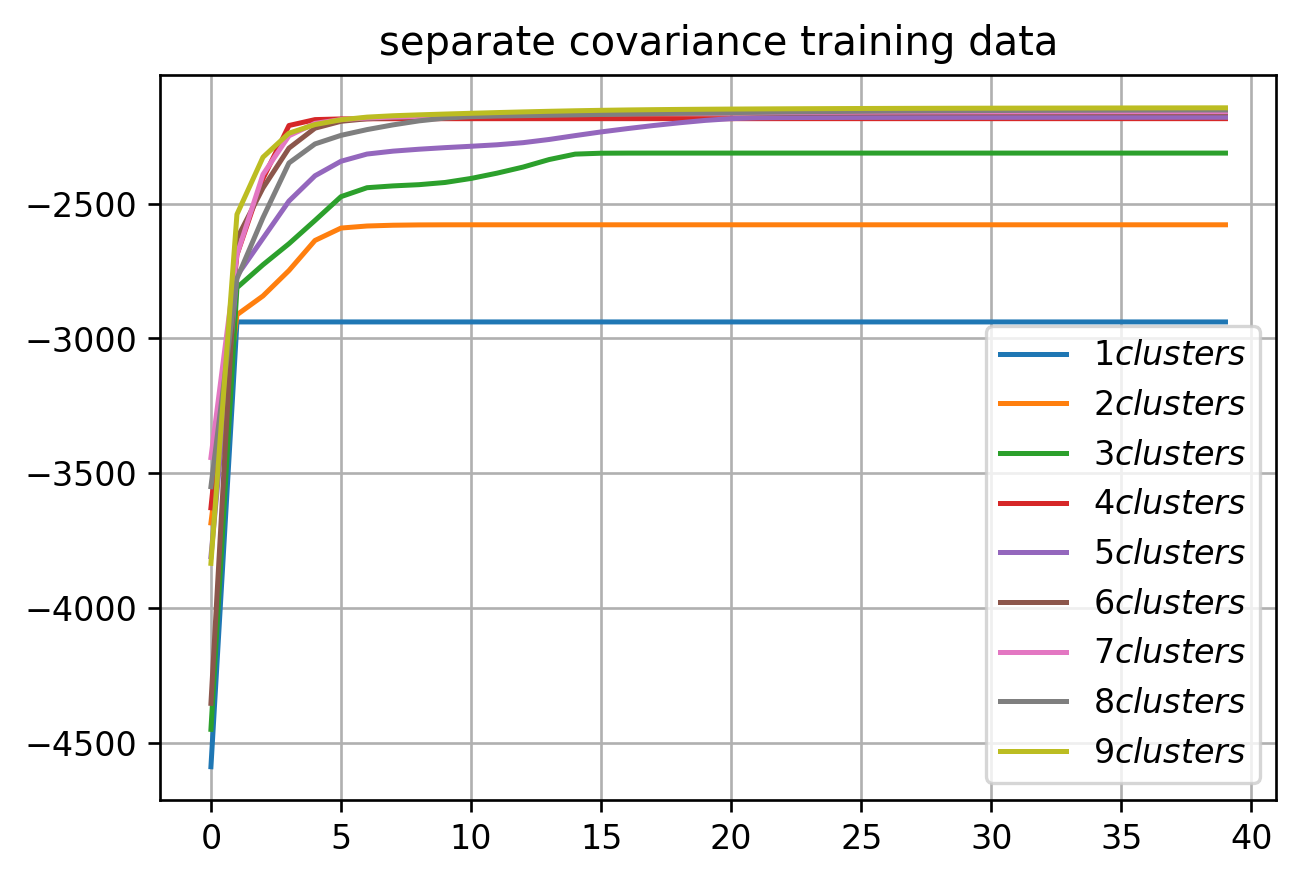

In [51]:

for i in range(9):
    plt.plot(x_axe, sep_result_train[i],label='$ %i clusters$' % (i+1))
plt.title('separate covariance training data')
plt.legend()
plt.grid(True)

plt.show()


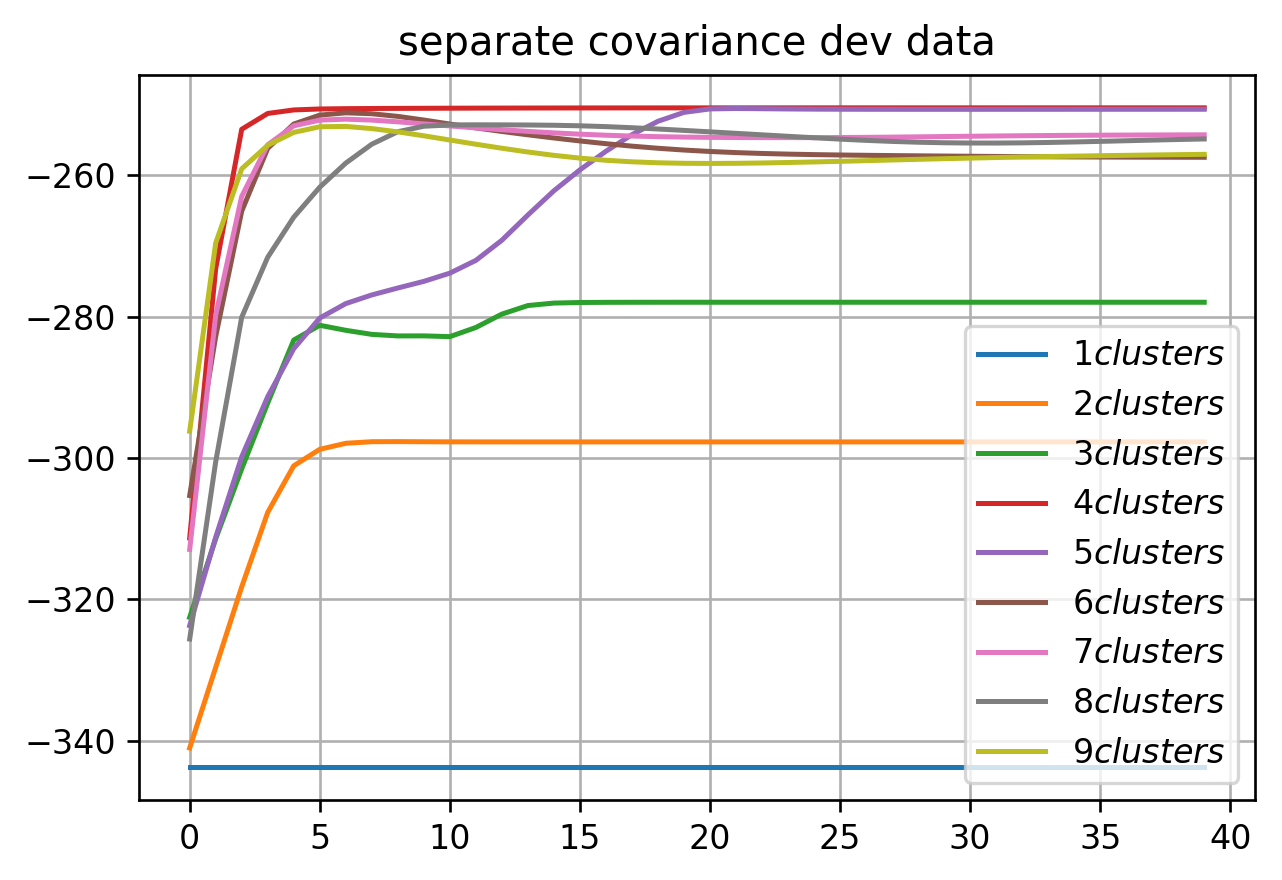

In [52]:

for i in range(9):
    plt.plot(x_axe, sep_result_dev[i],label='$ %i clusters$' % (i+1))

plt.title('separate covariance dev data')
plt.legend()
plt.grid(True)

plt.show()